The following is an analytical examination of some factors influencing the time a game of Crazy Eights lasts. It was inspired by a particularly long game the author recently played which, based on this analysis, had less than a 0.4% chance of occuring. We assume that game time is measured in 'turns', where each play by a given player is considered a turn.

Crazy Eights is a card game for two or more players, in which the object is to get rid of the cards in your hand onto a discard pile by matching the number or suit of the previous discard. The basic game of Crazy Eights uses a standard 52 card pack, or two such packs shuffled together if there are a lot of players. Here, we will assume that only a single pack is used.

Seven cards are dealt to each of the players, and the remainder of the pack is stacked face down on the table as a stock from which cards will be drawn. The top card of the stock is turned face up and placed beside the stock to start the discard pile. Starting with the player on the dealer's left and continuing clockwise, each player in turn must either play a legal card face up on top of the discard pile, or draw a card from the undealt stock. The following are considered legal play:

* If the top card of the discard pile is not an Eight, the player may play any card which matches the rank or suit of the previous card (for example if the top card was the king of hearts the player could play any king or any heart).

* An Eight may be played on any card, and the player of the Eight must nominate a suit.

* If an Eight is on top of the pile, the player must play either another Eight or any card of the suit nominated by the person who played the Eight.

* If an Eight is turned up by the dealer as the first card of the play pile, it is treated as though the dealer had played it. The dealer looks at his or her hand and nominates a suit, and the first player must play a card of that suit or another Eight.

* The first player who gets rid of all their cards wins.

Below, we implement and study the game of Crazy Eights in Python. This study uses simulations, and so all players are computers, and are assumed to play according to the rules specified above, choosing random drops when multiple options exist. Another crucial assumption is that suits are switched at random when an eight appears. This is unrealistic, but used for the purpose of simplicity.

In [58]:
#############################################
############ DEFINING GAMEPLAY ##############
#############################################

#Importing packages
from abc import abstractmethod, ABCMeta
from itertools import cycle, product
from random import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Card deck initialization
RANKS = '23456789TJQKA'
SUITS = 'CDHS'
INITIAL_CARDS = 7

#Defining class for stack of cards
class Pile(list):
    #Creating a sequence for the cards
    def __str__(self):
        return ' '.join(self)
    @property
    def top(self):
        #Card at the top of the stack
        return self[-1]
    def transfer(self, dest, card=None):
        #Moving card and replacing from top of pile
        if card is None:
            card = self.top
        self.remove(card)
        dest.append(card)
        return card

#Defining Player class representing computer/human players
class Player(object, metaclass=ABCMeta):
    def __init__(self, game):
        self.game = game
        self.hand = Pile()
    def can_play_on(self, card, other):
        #True if play is allowed
        return any(c == o for c, o in zip(card, other))
    def draw(self):
        #Draws and replaces card
        return self.game.draw.transfer(self.hand)
    def discard(self, card=None):
        #Discards and replaces card
        return self.hand.transfer(self.game.discard, card)
    @abstractmethod
    def play(self):
        #Playing a turn
        pass

#Defining Computer player class
class Computer(Player):
    #Defining play for each turn
    def play(self):
        for card in self.hand:
            if self.can_play_on(card, self.game.discard.top):
                self.discard(card)
                break
        else:
            self.draw()
        cards = len(self.hand) #Number of cards in hand

#Defining the Game class
class Game( object ):
    def __init__( self, num_players = 2, init_card_count = INITIAL_CARDS ):
        #Basic gameplay with number of players default to 2
        self.draw = Pile(''.join(card) for card in product(RANKS, SUITS))
        self.discard = Pile()
        self.players = [Computer(self)]*num_players
        shuffle(self.draw)
        for _, player in product(range(init_card_count), self.players):
            player.draw()
        self.draw.transfer(self.discard)
    def play(self, style = 'shuffle'):
        #Gameplay where the pile runs out
        counter = 0
        for player in cycle(self.players):
            counter = counter + 1
            player.play()
            if not player.hand:
                break #Player wins
            if not self.draw:
                self.draw, self.discard = self.discard, self.draw
                #Shuffling pile once exhausted
                if style == 'shuffle':
                    shuffle(self.draw)       
                #Reversing pile once exhausted    
                elif style == 'reverse':
                    self.draw.reverse()
                self.draw.transfer(self.discard)
            if not self.draw:
                break
        return counter #Returning number of gameplay turns


First, we consider the simple case of a game between two players, each beginning with 7 cards. Following the standard rules, the stack is shuffled once it is exhausted to allow gameplay to continue.

In [79]:
#####################################################
############ RUNNING BASIC SIMULATIONS ##############
#####################################################

import random

#Running simulations to examine generic gameplay time
random.seed( 789 )
num_sim = 10000
base_sim_store = list()

#Simulations below
for i in range( num_sim ):
    base_sim_store.append( Game( num_players = 2 ).play( 'shuffle' ) )
    
#Storing results
df_base = pd.DataFrame( { 'turns': base_sim_store } )
    

The basic summary statistics below show that an average game lasts around 84 turns. Assuming each player's turn takes approximately 5 seconds, this implies a game time of just over 7 minutes. The longest game in this set of simulations lasted 724 turns, implying a game time of over an hour! The shortest game is 14 turns. This is intuitive: even in the case where a player can put down a card each turn, it would take a minimum of 7 moves for that player, or 14 turns, for the player to win.

In [80]:
#######################################################
############ ANALYZING BASIC SIMULATIONS ##############
#######################################################

#Understanding summary statistics
print( 'Mean # of Turns: ' + str( round( df_base.turns.mean(), 2 ) ) )
print( 'Std Dev of Turns: ' + str( round( df_base.turns.std(), 2 ) ) )
print( 'Max # of Turns: ' + str( df_base.turns.max() ) )
print( 'Min # of Turns: ' + str( df_base.turns.min() ) )


Mean # of Turns: 84.35
Std Dev of Turns: 70.66
Max # of Turns: 724
Min # of Turns: 14


The distribution of game times is shown below.

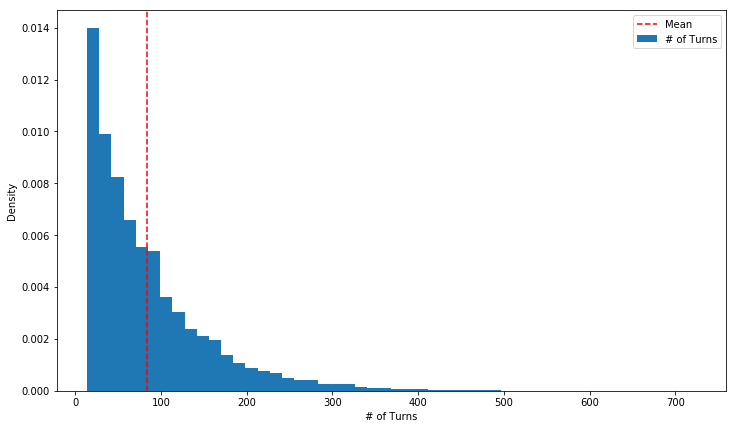

In [81]:
#Studying distribution of turns
plt.figure( figsize = ( 12, 7 ) )
plt.hist( df_base.turns, bins = 50, density = True, alpha=1, label='# of Turns')
plt.axvline( x= df_base.turns.mean(), color='r', linestyle='--', label = 'Mean')
plt.xlabel( "# of Turns" )
plt.ylabel( "Density" ) 
plt.legend(loc='upper right')
plt.show()


One variant of gameplay involves the approach taken when the central pile is exhausted. Conventional rules would suggest that shuffling the used pile before re-use is best, but in practice, this is time consuming and players will just reverse the used pile for a fresh start. How would this choice affect game time? This is examined below. 

In [82]:
#############################################################
############ RUNNING PILE VARIABLE SIMULATIONS ##############
#############################################################

#Running simulations to examine variation in gameplay time following shuffling vs reversing pile

num_sim = 10000
shuffle_sim_store = list()
reverse_sim_store = list()

#Simulations below
for i in range( num_sim ):
    shuffle_sim_store.append( Game( num_players = 2 ).play( 'shuffle' ) )
    reverse_sim_store.append( Game( num_players = 2 ).play( 'reverse' ) )
    
#Storing results
df_pile_comp = pd.DataFrame( { 'turns_shuffle': shuffle_sim_store, 'turns_reverse': reverse_sim_store } )
    

The summary statistics below show that this choice can have significant implications: the average game with the pile reversed instead of shuffled is 69 turns long, much shorter than the 85 turn average where the pile is shuffled. The maximum number of turns is also reduced quite a bit.

In [84]:
###############################################################
############ ANALYZING PILE VARIABLE SIMULATIONS ##############
#######################################################

#Understanding summary statistics in case of shuffle
print( 'Scenario: Shuffle' )
print( 'Mean # of Turns: ' + str( round( df_pile_comp.turns_shuffle.mean(), 2 ) ) )
print( 'Std Dev of Turns: ' + str( round( df_pile_comp.turns_shuffle.std(), 2 ) ) )
print( 'Max # of Turns: ' + str( df_pile_comp.turns_shuffle.max() ) )
print( 'Min # of Turns: ' + str( df_pile_comp.turns_shuffle.min() ) )

#Understanding summary statistics in case of reverse
print( '\n' )
print( 'Scenario: Reverse' )
print( 'Mean # of Turns: ' + str( round( df_pile_comp.turns_reverse.mean(), 2 ) ) )
print( 'Std Dev of Turns: ' + str( round( df_pile_comp.turns_reverse.std(), 2 ) ) )
print( 'Max # of Turns: ' + str( df_pile_comp.turns_reverse.max() ) )
print( 'Min # of Turns: ' + str( df_pile_comp.turns_reverse.min() ) )


Scenario: Shuffle
Mean # of Turns: 85.6
Std Dev of Turns: 71.78
Max # of Turns: 902
Min # of Turns: 14


Scenario: Reverse
Mean # of Turns: 69.41
Std Dev of Turns: 42.21
Max # of Turns: 388
Min # of Turns: 14


This holds true for the entire distribution. With the pile being reversed instead of shuffled, shorter game times are far more likely in general. Interestingly, the distribution appears to be almost bi-modal, as seen below.

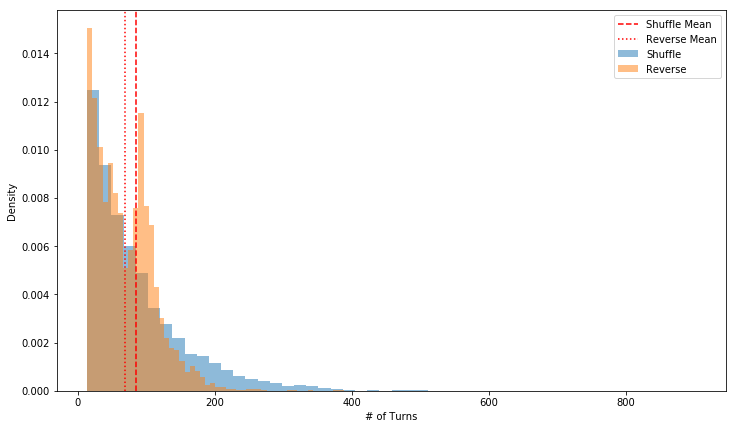

In [86]:
#Studying distribution of turns
plt.figure( figsize = ( 12, 7 ) )
plt.hist( df_pile_comp.turns_shuffle, bins = 50, density = True, alpha=0.5, label='Shuffle')
plt.axvline( x= df_pile_comp.turns_shuffle.mean(), color='r', linestyle='--', label = 'Shuffle Mean')
plt.hist( df_pile_comp.turns_reverse, bins = 50, density = True, alpha=0.5, label='Reverse')
plt.axvline( x= df_pile_comp.turns_reverse.mean(), color='r', linestyle=':', label = 'Reverse Mean')
plt.xlabel( "# of Turns" )
plt.ylabel( "Density" )
plt.legend(loc='upper right')
plt.show()


Crazy Eights requires a minimum of two players. But any number of players could play, although more card decks may be required. Below, we assume a single deck is used, and the number of players is varied, capped at 7 (since each player starts with 7 cards, and the standard deck would not allow for 8 players).

In [87]:
###########################################################################
############ RUNNING SIMULATIONS WITH VARIABLES # OF PLAYERS ##############
###########################################################################

#Running simulations to examine variation in gameplay time with the number of players

num_sim = 10000
player_count = 6 
player_count = min( player_count, 7 ) #Capped at 7 since each player is assumed to start with 7 cards

sim_store_p = list()
for i in range( player_count-1 ):
    sim_store_p.append( list() )

#Simulations below
for i in range( num_sim ):
    for j in range( player_count-1 ):
        sim_store_p[ j ].append( Game( num_players = j+2 ).play( 'shuffle' ) )
    
#Storing results
df_player_comp = pd.DataFrame()
for j in range( player_count-1 ):
    df_player_comp[ 'turns_' + str( j+2 ) + 'p' ] = sim_store_p[ j ]
    

As one would expect, game time increases with the number of players: it would take any given player more turns to be able to drop all his/her cards. The minimum number of turns is, as before, the product of the number of players and the initial number of cards. We note that the maximum game time does not increase as steadily as the mean, and that the standard deviation of game time is remarkably consistent as the number of players is varied.

In [88]:
#################################################################
############ ANALYZING PLAYER VARIABLE SIMULATIONS ##############
#################################################################

#Studying summary statistics in each case
df_sum_stats = pd.DataFrame()
frame_cols = list( df_player_comp.columns )
mean_store = list()
std_store = list()
max_store = list()
min_store = list()

for col in frame_cols:
    mean_store.append( round( df_player_comp[ col ].mean(), 2 ) )
    std_store.append( round( df_player_comp[ col ].std(), 2 ) )
    max_store.append( df_player_comp[ col ].max() )
    min_store.append( df_player_comp[ col ].min() )

#Aggregating into Table
df_sum_stats[ 'Players'] = list( range( 2, 2 + len( mean_store ) ) )
df_sum_stats[ 'Mean' ] = mean_store
df_sum_stats[ 'Std Dev' ] = std_store
df_sum_stats[ 'Max' ] = max_store
df_sum_stats[ 'Min' ] = min_store

print( df_sum_stats )



   Players    Mean  Std Dev  Max  Min
0        2   85.17    71.03  684   14
1        3   93.54    73.60  871   21
2        4   99.45    71.31  622   28
3        5  105.54    71.06  617   35
4        6  113.17    72.64  658   42


The plot below illustrates the monotonic increase in game time with the number of players.

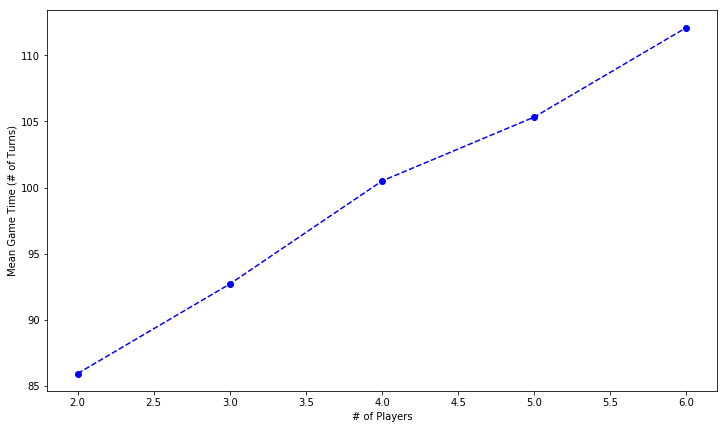

In [53]:
#Visualizing change in mean game time
plt.figure( figsize = ( 12, 7 ) )
plt.plot( df_sum_stats[ 'Players' ], df_sum_stats[ 'Mean' ], linestyle='--', marker='o', color='b')
plt.xlabel( '# of Players' )
plt.ylabel( 'Mean Game Time (# of Turns)' )
plt.show()

The plot below illustrates the distributions of game times. Since the minimum game time keeps increasing, the distributions shift rightwards. We also note that shorter game times are less likely as the number of players increases, that is, the density starts to increase at higher gameplay times.

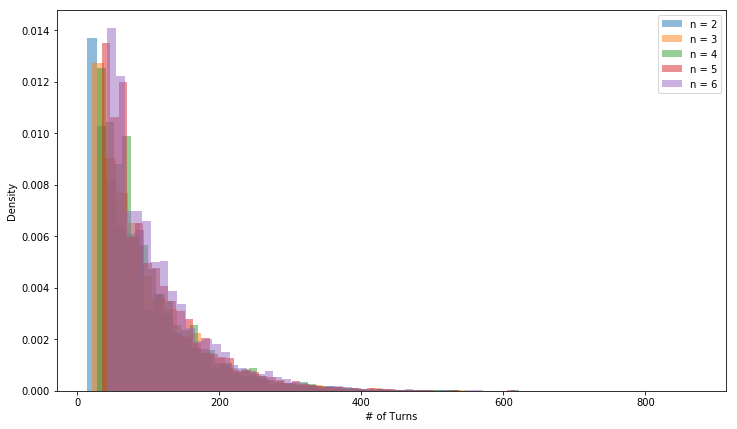

In [89]:
#Studying distribution of turns
plt.figure( figsize = ( 12, 7 ) )
for col in list( df_player_comp.columns ):
    plt.hist( df_player_comp[ col ], bins = 50, density = True, alpha=0.5, label= 'n = ' + col[ -2:-1 ] )
plt.xlabel( "# of Turns" )
plt.ylabel( "Density" )
plt.legend(loc='upper right')
plt.show()


We now vary the number of cards given to each player at the start of the game. We will return to the case of two players, and the initial number of cards (assumed to be 7 previously) is changed. Note that some versions of the game reduce the initial card allocation to 5 per player. The reason should be clear from the discussion above: 5 cards will make for quicker games, and less need for re-shuffling the used pile!

In [90]:
################################################################################
############ RUNNING SIMULATIONS WITH VARIABLE INITIAL CARD COUNT ##############
################################################################################

#Running simulations to examine variation in gameplay time with the initial number of cards

num_sim = 10000
starting_card_count = 20 #Capping card count at 20

sim_store_c = list()
for i in range( starting_card_count - 7 ):
    sim_store_c.append( list() )

#Simulations below
for i in range( num_sim ):
    for j in range( starting_card_count - 7 ):
        sim_store_c[ j ].append( Game( init_card_count = j+7 ).play( 'shuffle' ) )
    
#Storing results
df_card_comp = pd.DataFrame()
for j in range( starting_card_count - 7 ):
    df_card_comp[ 'turns_' + str( j+7 ) + 'c' ] = sim_store_c[ j ]



Mean game time increases steadily, and as in the cases above, the same pattern is not noted for maximum gameplay time, or for the standard deviation of game time, both of which are stable. The minimum game play time follows the expected pattern.

In [92]:
#################################################################
############ ANALYZING PLAYER VARIABLE SIMULATIONS ##############
#################################################################

#Studying summary statistics in each case
df_sum_stats = pd.DataFrame()
frame_cols = list( df_card_comp.columns )
mean_store = list()
std_store = list()
max_store = list()
min_store = list()

for col in frame_cols:
    mean_store.append( round( df_card_comp[ col ].mean(), 2 ) )
    std_store.append( round( df_card_comp[ col ].std(), 2 ) )
    max_store.append( df_card_comp[ col ].max() )
    min_store.append( df_card_comp[ col ].min() )

#Aggregating into Table
df_sum_stats[ 'Initial Card Count'] = list( range( 7, 7 + len( mean_store ) ) )
df_sum_stats[ 'Mean' ] = mean_store
df_sum_stats[ 'Std Dev' ] = std_store
df_sum_stats[ 'Max' ] = max_store
df_sum_stats[ 'Min' ] = min_store

print( df_sum_stats )



    Initial Card Count    Mean  Std Dev  Max  Min
0                    7   84.99    70.90  706   14
1                    8   87.45    72.27  684   16
2                    9   89.43    71.79  768   18
3                   10   90.55    70.01  740   20
4                   11   92.92    71.04  638   22
5                   12   95.48    71.71  676   24
6                   13   96.59    70.94  668   26
7                   14   99.53    72.27  664   28
8                   15  101.65    71.40  774   30
9                   16  103.37    72.71  790   32
10                  17  104.41    72.73  826   34
11                  18  106.46    71.59  598   36
12                  19  108.51    71.35  742   38


The increase in average gameplay time is less steep than seen before, but still appears mostly monotonic.

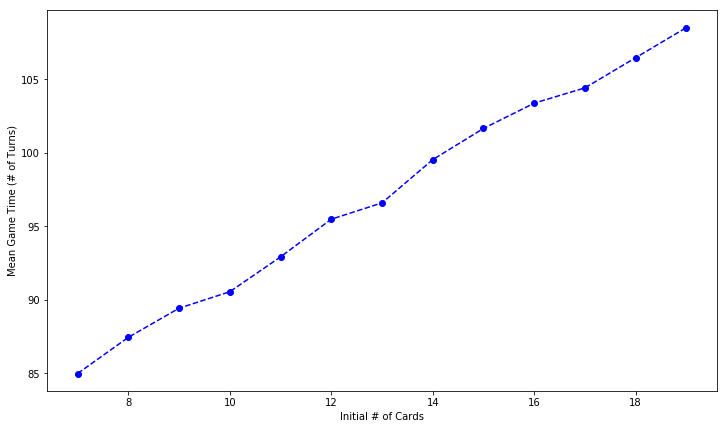

In [93]:
#Visualizing change in mean game time
plt.figure( figsize = ( 12, 7 ) )
plt.plot( df_sum_stats[ 'Initial Card Count' ], df_sum_stats[ 'Mean' ], linestyle='--', marker='o', color='b')
plt.xlabel( 'Initial # of Cards' )
plt.ylabel( 'Mean Game Time (# of Turns)' )
plt.show()

The distribution of gameplay times is plotted below for the cases with 8, 12 and 16 initial cards. The probability of short game times is reduced, and greater density is shifted towards intermediate game times. This is consistent with the summary statistics: neither maximum time nor standard deviation is changed, and an increase in minimum time is observed. This would suggest a shift in probability mass towards intermediate gameplay times. 

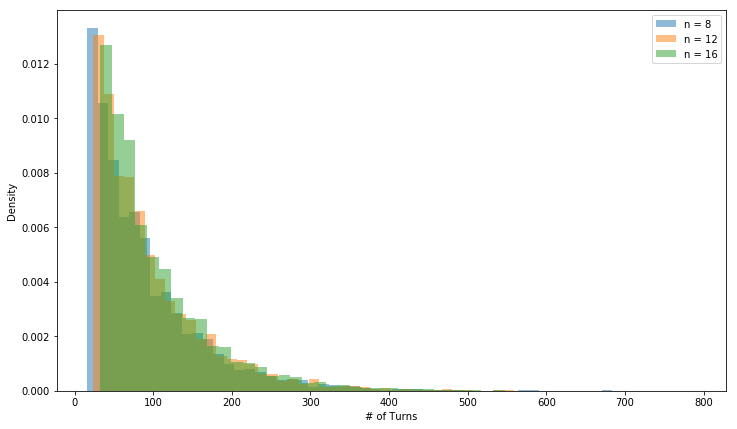

In [95]:
#Studying distribution of turns
plt.figure( figsize = ( 12, 7 ) )
plt.hist( df_card_comp[ 'turns_8c' ], bins = 50, density = True, alpha=0.5, label= 'n = 8' )
plt.hist( df_card_comp[ 'turns_12c' ], bins = 50, density = True, alpha=0.5, label= 'n = 12' )
plt.hist( df_card_comp[ 'turns_16c' ], bins = 50, density = True, alpha=0.5, label= 'n = 16' )
plt.xlabel( "# of Turns" )
plt.ylabel( "Density" )
plt.legend(loc='upper right')
plt.show()


The brief study above illustrates some of the fascinating patterns that can arise as a result of small variations made to even the simplest of games. An interesting point of further study would be to see how a 'smart' player could cut down game time. Realistically, a player could infer the suits/values of the card held by his/her opponents, and strategically choose which cards to drop down when possible, and what suit to switch to when an eight is available. This sort of gameplay could cut game time if one, or few players do it. But what if everyone plays strategically? By sabotaging each other's efforts to win, game time could be extended considerably. To be revisited!